Implement a Gaze-LLE to keep track of who is looking at who

In [ ]:
%pip install timm
%pip install RetinaFace

In [2]:
%pip install torch

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.12.2 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch

# load Gaze-LLE model
model, transform = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitl14_inout')

model.eval()
model.to('cpu')

ImportError: cannot import name 'Self' from 'typing_extensions' (/opt/miniconda3/envs/office/lib/python3.9/site-packages/typing_extensions.py)

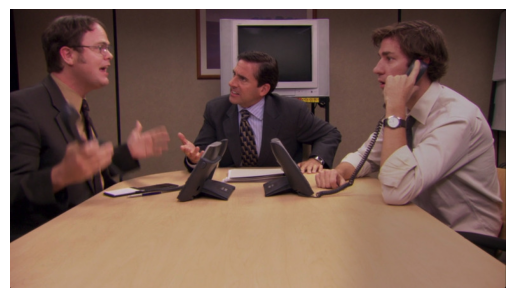

In [21]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import numpy as np

# load an input image

image_url = "https://www.looper.com/img/gallery/the-office-funniest-moments-ranked/jim-and-dwights-customer-service-training-1627594561.jpg"
# image_url = "https://ew.com/thmb/n5b8Asz4Y5Lp0sSEF7WgS-ESyFc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/succession-finale-052923-ec304aabcbf24a7b9fad891a87f49b74.jpg"
# image_url = "https://i.kym-cdn.com/entries/icons/original/000/045/575/blackcatzoningout_meme.jpg"

try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    image = Image.open(BytesIO(response.content))
    width, height = image.size

    plt.imshow(image)
    plt.axis('off')
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

{'face_1': {'score': 0.9995856881141663, 'facial_area': [343, 80, 393, 148], 'landmarks': {'right_eye': [351.53635, 104.45876], 'left_eye': [364.2473, 109.84246], 'nose': [345.343, 118.26524], 'mouth_right': [349.05673, 129.60373], 'mouth_left': [358.86234, 133.21274]}}, 'face_2': {'score': 0.9990641474723816, 'facial_area': [102, 28, 161, 119], 'landmarks': {'right_eye': [141.36621, 60.725178], 'left_eye': [151.70895, 62.105152], 'nose': [160.81204, 76.4635], 'mouth_right': [140.18956, 93.66838], 'mouth_left': [149.57648, 95.37327]}}, 'face_3': {'score': 0.9970555305480957, 'facial_area': [574, 44, 633, 135], 'landmarks': {'right_eye': [582.76074, 78.513145], 'left_eye': [595.2832, 79.6683], 'nose': [575.6908, 95.97691], 'mouth_right': [584.42566, 114.132965], 'mouth_left': [592.5642, 114.5779]}}}
[[343, 80, 393, 148], [102, 28, 161, 119], [574, 44, 633, 135]]
torch.Size([64, 64])
0.9942521452903748


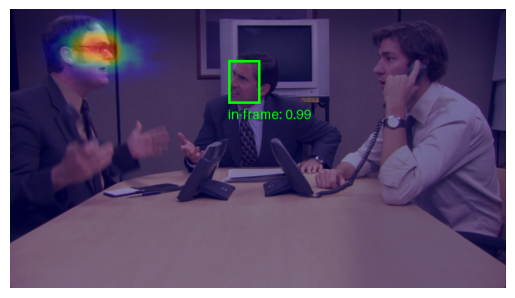

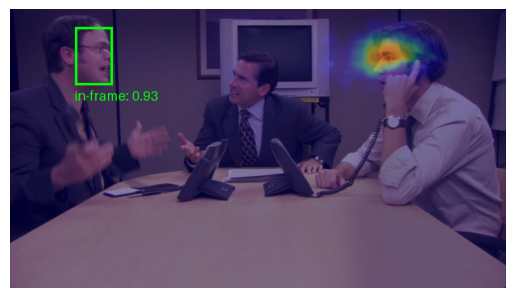

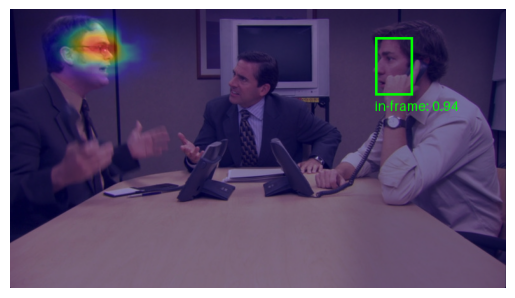

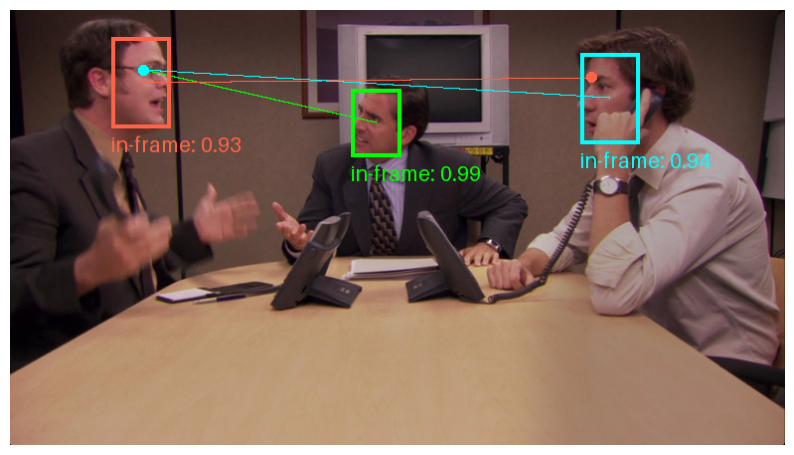

In [22]:
# detect faces
resp = RetinaFace.detect_faces(np.array(image))
print(resp)
bboxes = [resp[key]['facial_area'] for key in resp.keys()]
print(bboxes)
# prepare gazelle input
img_tensor = transform(image).unsqueeze(0).to('cpu')
norm_bboxes = [[np.array(bbox) / np.array([width, height, width, height]) for bbox in bboxes]]

input = {
    "images": img_tensor, # [num_images, 3, 448, 448]
    "bboxes": norm_bboxes # [[img1_bbox1, img1_bbox2...], [img2_bbox1, img2_bbox2]...]
}

with torch.no_grad():
    output = model(input)

img1_person1_heatmap = output['heatmap'][0][0] # [64, 64] heatmap
print(img1_person1_heatmap.shape)
if model.inout:
  img1_person1_inout = output['inout'][0][0] # gaze in frame score (if model supports inout prediction)
  print(img1_person1_inout.item())

# visualize predicted gaze heatmap for each person and gaze in/out of frame score

def visualize_heatmap(pil_image, heatmap, bbox=None, inout_score=None):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(pil_image.size, Image.Resampling.BILINEAR)
    heatmap = plt.cm.jet(np.array(heatmap) / 255.)
    heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
    heatmap = Image.fromarray(heatmap).convert("RGBA")
    heatmap.putalpha(90)
    overlay_image = Image.alpha_composite(pil_image.convert("RGBA"), heatmap)

    if bbox is not None:
        width, height = pil_image.size
        xmin, ymin, xmax, ymax = bbox
        draw = ImageDraw.Draw(overlay_image)
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline="lime", width=int(min(width, height) * 0.01))

        if inout_score is not None:
          text = f"in-frame: {inout_score:.2f}"
          text_width = draw.textlength(text)
          text_height = int(height * 0.01)
          text_x = xmin * width
          text_y = ymax * height + text_height
          draw.text((text_x, text_y), text, fill="lime", font=ImageFont.load_default(size=int(min(width, height) * 0.05)))
    return overlay_image

for i in range(len(bboxes)):
  plt.figure()
  plt.imshow(visualize_heatmap(image, output['heatmap'][0][i], norm_bboxes[0][i], inout_score=output['inout'][0][i] if output['inout'] is not None else None))
  plt.axis('off')
  plt.show()

# combined visualization with maximal gaze points for each person

def visualize_all(pil_image, heatmaps, bboxes, inout_scores, inout_thresh=0.5):
    colors = ['lime', 'tomato', 'cyan', 'fuchsia', 'yellow']
    overlay_image = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(overlay_image)
    width, height = pil_image.size

    for i in range(len(bboxes)):
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        color = colors[i % len(colors)]
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline=color, width=int(min(width, height) * 0.01))

        if inout_scores is not None:
            inout_score = inout_scores[i]
            text = f"in-frame: {inout_score:.2f}"
            text_width = draw.textlength(text)
            text_height = int(height * 0.01)
            text_x = xmin * width
            text_y = ymax * height + text_height
            draw.text((text_x, text_y), text, fill=color, font=ImageFont.load_default(size=int(min(width, height) * 0.05)))

        if inout_scores is not None and inout_score > inout_thresh:
            heatmap = heatmaps[i]
            heatmap_np = heatmap.detach().cpu().numpy()
            max_index = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
            gaze_target_x = max_index[1] / heatmap_np.shape[1] * width
            gaze_target_y = max_index[0] / heatmap_np.shape[0] * height
            bbox_center_x = ((xmin + xmax) / 2) * width
            bbox_center_y = ((ymin + ymax) / 2) * height

            draw.ellipse([(gaze_target_x-5, gaze_target_y-5), (gaze_target_x+5, gaze_target_y+5)], fill=color, width=int(0.005*min(width, height)))
            draw.line([(bbox_center_x, bbox_center_y), (gaze_target_x, gaze_target_y)], fill=color, width=int(0.005*min(width, height)))

    return overlay_image

plt.figure(figsize=(10,10))
plt.imshow(visualize_all(image, output['heatmap'][0], norm_bboxes[0], output['inout'][0] if output['inout'] is not None else None, inout_thresh=0.5))
plt.axis('off')
plt.show()




In [1]:

import cv2
import torch
import numpy as np
from PIL import Image
from retinaface import RetinaFace
from yt_dlp import YoutubeDL
import matplotlib.pyplot as plt

# Function to fetch video URL using yt-dlp
def get_video_url(youtube_url):
    ydl_opts = {'quiet': True, 'format': 'best[ext=mp4]'}
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_url, download=False)
        return info['url']

# Function to visualize the gaze heatmap and gaze target
def visualize_gaze(frame, heatmap, bbox):
    height, width, _ = frame.shape
    x1, y1, x2, y2 = bbox

    # Scale heatmap to image size
    heatmap_resized = cv2.resize(heatmap.cpu().numpy(), (width, height))
    heatmap_overlay = (heatmap_resized * 255).astype(np.uint8)
    heatmap_colored = cv2.applyColorMap(heatmap_overlay, cv2.COLORMAP_JET)

    # Add transparency to heatmap
    overlay = cv2.addWeighted(frame, 0.7, heatmap_colored, 0.3, 0)

    # Draw bounding box
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Find gaze target (highest probability in heatmap)
    max_idx = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)
    gaze_x, gaze_y = max_idx[1], max_idx[0]
    cv2.circle(overlay, (gaze_x, gaze_y), radius=5, color=(255, 0, 0), thickness=-1)
    cv2.line(overlay, ((x1 + x2) // 2, (y1 + y2) // 2), (gaze_x, gaze_y), (0, 255, 255), 2)

    return overlay

# Add a frame skip interval
FRAME_SKIP = 20  # Process every 5th frame

# Process YouTube live stream
youtube_url = "https://www.youtube.com/watch?v=96Y6mc3C1Bg"  # Replace with your URL
video_url = get_video_url(youtube_url)
cap = cv2.VideoCapture(video_url)

if not cap.isOpened():
    print("Error: Unable to open the YouTube video stream.")
else:
    print("Processing YouTube video. Press 'q' to quit.")
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading the video stream.")
            break

        # Skip frames
        if frame_count % FRAME_SKIP != 0:
            frame_count += 1
            continue

        # Face detection with RetinaFace
        detections = RetinaFace.detect_faces(frame)
        if detections:
            bounding_boxes = [detections[key]["facial_area"] for key in detections.keys()]

            # Prepare Gaze-LLE inputs
            pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            input_tensor = transform(pil_image).unsqueeze(0)
            norm_bboxes = [[np.array(bbox) / np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]]) for bbox in bounding_boxes]]

            input_data = {
                "images": input_tensor,
                "bboxes": norm_bboxes
            }

            # Predict gaze heatmaps
            with torch.no_grad():
                output = model(input_data)

            # Visualize results
            for i, bbox in enumerate(bounding_boxes):
                heatmap = output["heatmap"][0][i]
                frame = visualize_gaze(frame, heatmap, bbox)

        # Display frame with gaze visualization
        cv2.imshow("Gaze-LLE on YouTube Live Stream", frame)

        # Exit on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Exiting video processing.")
            break

        frame_count += 1

cap.release()
cv2.destroyAllWindows()


ImportError: cannot import name 'Self' from 'typing_extensions' (/opt/miniconda3/envs/office/lib/python3.9/site-packages/typing_extensions.py)